### Import Resources 

In the next python cell, we load in the required libraries for this section of the project.

In [1]:
# Import required libraries for this section

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import cv2                     # OpenCV library for computer vision
from PIL import Image
import time 

Next, we load in and display a test image for performing face detection.

*Note*: by default OpenCV assumes the ordering of our image's color channels are Blue, then Green, then Red.  This is slightly out of order with most image types we'll use in these experiments, whose color channels are ordered Red, then Green, then Blue.  In order to switch the Blue and Red channels of our test image around we will use OpenCV's ```cvtColor``` function, which you can read more about by [checking out some of its documentation located here](http://docs.opencv.org/3.2.0/df/d9d/tutorial_py_colorspaces.html).  This is a general utility function that can do other transformations too like converting a color image to grayscale, and transforming a standard color image to HSV color space.

---
<a id='step1'></a>

## Step 1: Add Eye Detections

There are other pre-trained detectors available that use a Haar Cascade Classifier - including full human body detectors, license plate detectors, and more.  [A full list of the pre-trained architectures can be found here](https://github.com/opencv/opencv/tree/master/data/haarcascades). 

To test your eye detector, we'll first read in a new test image with just a single face.

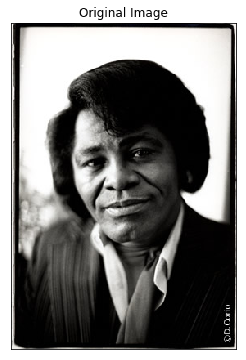

In [3]:
# Load in color image for face detection
image = cv2.imread('images/james.jpg')

# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the RGB image
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image')
ax1.imshow(image)

Notice that even though the image is a black and white image, we have read it in as a color image and so it will still need to be converted to grayscale in order to perform the most accurate face detection.

So, the next steps will be to convert this image to grayscale, then load OpenCV's face detector and run it with parameters that detect this face accurately.

Number of faces detected: 1


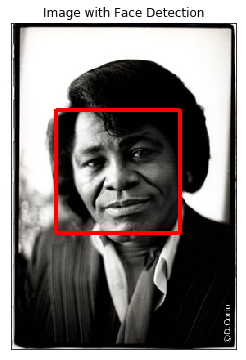

In [4]:
# Convert the RGB  image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Extract the pre-trained face detector from an xml file
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Detect the faces in image
faces = face_cascade.detectMultiScale(gray, 1.25, 6)

# Print the number of faces detected in the image
print('Number of faces detected:', len(faces))

# Make a copy of the orginal image to draw face detections on
image_with_detections = np.copy(image)

# Get the bounding box for each detected face
for (x,y,w,h) in faces:
    # Add a red bounding box to the detections image
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3)
    

# Display the image with the detections
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Image with Face Detection')
ax1.imshow(image_with_detections)

### (IMPLEMENTATION) Add an eye detector to the current face detection setup.  

A Haar-cascade eye detector can be included in the same way that the face detector was and, in this first task, it will be your job to do just this.

To set up an eye detector, use the stored parameters of the eye cascade detector, called ```haarcascade_eye.xml```, located in the `detector_architectures` subdirectory.  In the next code cell, create your eye detector and store its detections.

**A few notes before you get started**: 

First, make sure to give your loaded eye detector the variable name

``eye_cascade``


and give the list of eye regions you detect the variable name 

``eyes``

Second, since we've already run the face detector over this image, you should only search for eyes *within the rectangular face regions detected in ``faces``*.  This will minimize false detections.

Lastly, once you've run your eye detector over the facial detection region, you should display the RGB image with both the face detection boxes (in red) and your eye detections (in green) to verify that everything works as expected.

There are 2 eyes


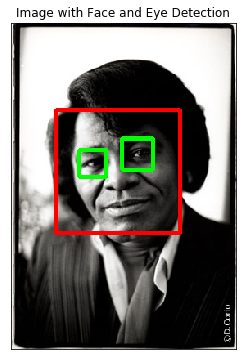

In [6]:
# Make a copy of the original image to plot rectangle detections
image_with_detections = np.copy(image)   

# Loop over the detections and draw their corresponding face detection boxes
for (x,y,w,h) in faces:
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h),(255,0,0), 3)  
    
# Do not change the code above this comment!

eyes_cascade = cv2.CascadeClassifier("detector_architectures/haarcascade_eye.xml")

if (eyes_cascade is None):
    print("No eyes classifier")
## TODO: Add eye detection, using haarcascade_eye.xml, to the current face detector algorithm
## TODO: Loop over the eye detections and draw their corresponding boxes in green on image_with_detections
for (x,y,w,h) in faces:
    face = gray[y:y+h, x:x+w]
    eyes = eyes_cascade.detectMultiScale(face)
    print("There are {} eyes".format(len(eyes)))
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(image_with_detections, (ex + x, ey + y), (ex+ew+x, ey+eh+y), (0,255,0), 3)

# Plot the image with both faces and eyes detected
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Image with Face and Eye Detection')
ax1.imshow(image_with_detections)

---
<a id='step2'></a>

## Step 2: De-noise an Image for Better Face Detection

Image quality is an important aspect of any computer vision task. Typically, when creating a set of images to train a deep learning network, significant care is taken to ensure that training images are free of visual noise or artifacts that hinder object detection.  While computer vision algorithms - like a face detector - are typically trained on 'nice' data such as this, new test data doesn't always look so nice!

When applying a trained computer vision algorithm to a new piece of test data one often cleans it up first before feeding it in.  This sort of cleaning - referred to as *pre-processing* - can include a number of cleaning phases like blurring, de-noising, color transformations, etc., and many of these tasks can be accomplished using OpenCV.

In this short subsection we explore OpenCV's noise-removal functionality to see how we can clean up a noisy image, which we then feed into our trained face detector.

### Create a noisy image to work with

In the next cell, we create an artificial noisy version of the previous multi-face image.  This is a little exaggerated - we don't typically get images that are this noisy - but [image noise](https://digital-photography-school.com/how-to-avoid-and-reduce-noise-in-your-images/), or 'grainy-ness' in a digitial image - is a fairly common phenomenon.

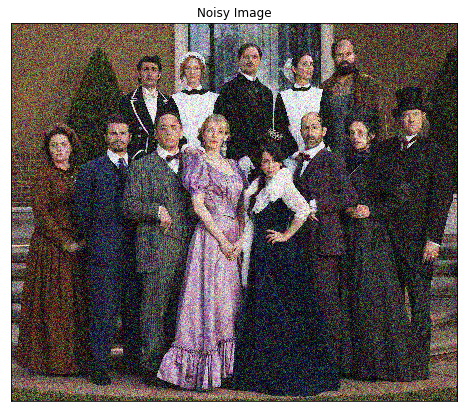

In [7]:
# Load in the multi-face test image again
image = cv2.imread('images/test_image_1.jpg')

# Convert the image copy to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Make an array copy of this image
image_with_noise = np.asarray(image)

# Create noise - here we add noise sampled randomly from a Gaussian distribution: a common model for noise
noise_level = 40
noise = np.random.randn(image.shape[0],image.shape[1],image.shape[2])*noise_level

# Add this noise to the array image copy
image_with_noise = image_with_noise + noise

# Convert back to uint8 format
image_with_noise = np.asarray([np.uint8(np.clip(i,0,255)) for i in image_with_noise])

# Plot our noisy image!
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Noisy Image')
ax1.imshow(image_with_noise)

In the context of face detection, the problem with an image like this is that  - due to noise - we may miss some faces or get false detections.  

In the next cell we apply the same trained OpenCV detector with the same settings as before, to see what sort of detections we get.

Number of faces detected: 12


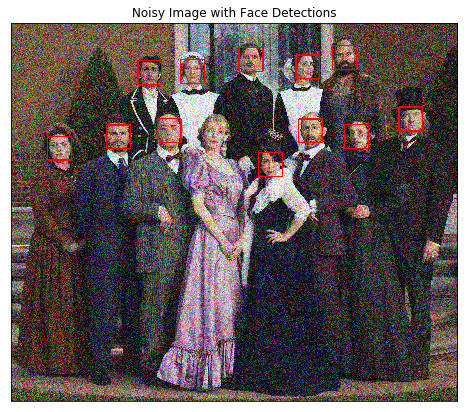

In [8]:
# Convert the RGB  image to grayscale
gray_noise = cv2.cvtColor(image_with_noise, cv2.COLOR_RGB2GRAY)

# Extract the pre-trained face detector from an xml file
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Detect the faces in image
faces = face_cascade.detectMultiScale(gray_noise, 4, 6)

# Print the number of faces detected in the image
print('Number of faces detected:', len(faces))

# Make a copy of the orginal image to draw face detections on
image_with_detections = np.copy(image_with_noise)

# Get the bounding box for each detected face
for (x,y,w,h) in faces:
    # Add a red bounding box to the detections image
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3)
    

# Display the image with the detections
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Noisy Image with Face Detections')
ax1.imshow(image_with_detections)

With this added noise we now miss one of the faces!

### (IMPLEMENTATION) De-noise this image for better face detection

Time to get your hands dirty: using OpenCV's built in color image de-noising functionality called ```fastNlMeansDenoisingColored``` - de-noise this image enough so that all the faces in the image are properly detected.  Once you have cleaned the image in the next cell, use the cell that follows to run our trained face detector over the cleaned image to check out its detections.

You can find its [official documentation here]([documentation for denoising](http://docs.opencv.org/trunk/d1/d79/group__photo__denoise.html#ga21abc1c8b0e15f78cd3eff672cb6c476) and [a useful example here](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_photo/py_non_local_means/py_non_local_means.html).


**Note:** you can keep all parameters *except* `photo_render` fixed as shown in the second link above.  Play around with the value of this parameter - see how it affects the resulting cleaned image.

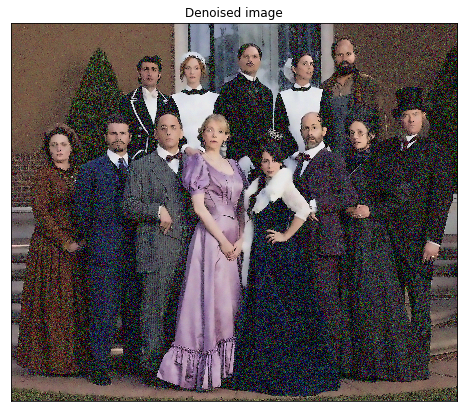

In [10]:
## TODO: Use OpenCV's built in color image de-noising function to clean up our noisy image!

# your final de-noised image (should be RGB)
denoised_image = cv2.fastNlMeansDenoisingColored(image_with_noise, None, 17, 17, 7, 21)
# Plot the image with both faces and eyes detected
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Denoised image')
ax1.imshow(denoised_image)

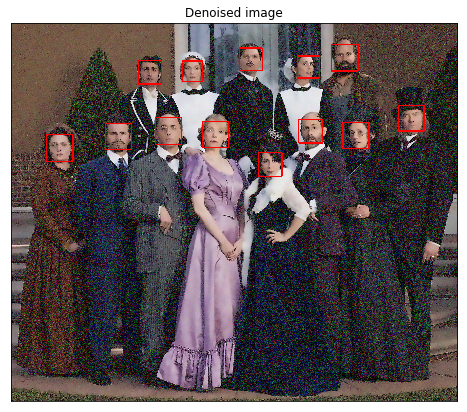

In [11]:
## TODO: Run the face detector on the de-noised image to improve your detections and display the result
faces = face_cascade.detectMultiScale(denoised_image, 1.25, 6)

for (x,y,w,h) in faces:
    # Add a red bounding box to the detections image
    cv2.rectangle(denoised_image, (x,y), (x+w,y+h), (255,0,0), 3)
# Plot the image with both faces and eyes detected
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Denoised image')
ax1.imshow(denoised_image)

---
<a id='step3'></a>

## Step 3: Blur an Image and Perform Edge Detection

Now that we have developed a simple pipeline for detecting faces using OpenCV - let's start playing around with a few fun things we can do with all those detected faces!

### Importance of Blur in Edge Detection

Edge detection is a concept that pops up almost everywhere in computer vision applications, as edge-based features (as well as features built on top of edges) are often some of the best features for e.g., object detection and recognition problems.

Edge detection is a dimension reduction technique - by keeping only the edges of an image we get to throw away a lot of non-discriminating information.  And typically the most useful kind of edge-detection is one that preserves only the important, global structures (ignoring local structures that aren't very discriminative).  So removing local structures / retaining global structures is a crucial pre-processing step to performing edge detection in an image, and blurring can do just that.  

Below is an animated gif showing the result of an edge-detected cat [taken from Wikipedia](https://en.wikipedia.org/wiki/Gaussian_blur#Common_uses), where the image is gradually blurred more and more prior to edge detection.  When the animation begins you can't quite make out what it's a picture of, but as the animation evolves and local structures are removed via blurring the cat becomes visible in the edge-detected image.

<img src="images/Edge_Image.gif" width=400 height=300/>

Edge detection is a **convolution** performed on the image itself, and you can read about Canny edge detection on [this OpenCV documentation page](http://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html).

### Canny edge detection

In the cell below we load in a test image, then apply *Canny edge detection* on it.  The original image is shown on the left panel of the figure, while the edge-detected version of the image is shown on the right.  Notice how the result looks very busy - there are too many little details preserved in the image before it is sent to the edge detector.  When applied in computer vision applications, edge detection should preserve *global* structure; doing away with local structures that don't help describe what objects are in the image.

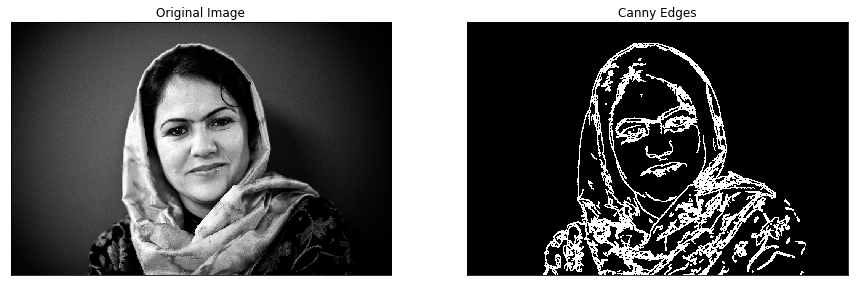

In [12]:
# Load in the image
image = cv2.imread('images/fawzia.jpg')

# Convert to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  

# Perform Canny edge detection
edges = cv2.Canny(gray,100,200)

# Dilate the image to amplify edges
edges = cv2.dilate(edges, None)

# Plot the RGB and edge-detected image
fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(121)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image')
ax1.imshow(image)

ax2 = fig.add_subplot(122)
ax2.set_xticks([])
ax2.set_yticks([])

ax2.set_title('Canny Edges')
ax2.imshow(edges, cmap='gray')

Without first blurring the image, and removing small, local structures, a lot of irrelevant edge content gets picked up and amplified by the detector (as shown in the right panel above). 

### (IMPLEMENTATION) Blur the image *then* perform edge detection

In the next cell, you will repeat this experiment - blurring the image first to remove these local structures, so that only the important boudnary details remain in the edge-detected image.

Blur the image by using OpenCV's ```filter2d``` functionality - which is discussed in [this documentation page](http://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html) - and use an *averaging kernel* of width equal to 4.

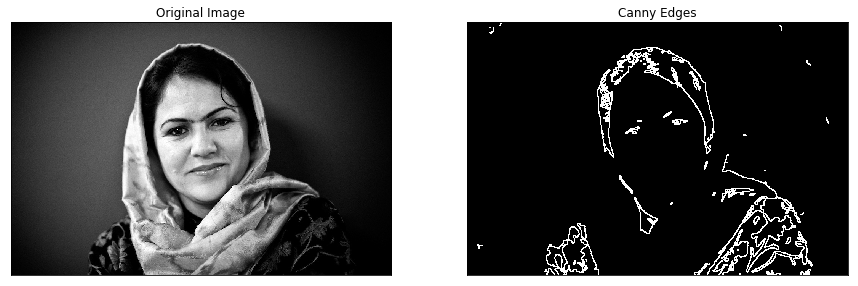

In [13]:
### TODO: Blur the test imageusing OpenCV's filter2d functionality, 
# Use an averaging kernel, and a kernel width equal to 4
image = cv2.imread('images/fawzia.jpg')

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  
kernel = np.array([
    [1, 1, 1, 1],
    [1, 1, 1, 1],
    [1, 1, 1, 1],
    [1, 1, 1, 1]
])
gray = cv2.filter2D(gray, -1, kernel)

## TODO: Then perform Canny edge detection and display the output

# Perform Canny edge detection
edges = cv2.Canny(gray,100,200)

# Dilate the image to amplify edges
edges = cv2.dilate(edges, None)

# Plot the RGB and edge-detected image
fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(121)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image')
ax1.imshow(image)

ax2 = fig.add_subplot(122)
ax2.set_xticks([])
ax2.set_yticks([])

ax2.set_title('Canny Edges')
ax2.imshow(edges, cmap='gray')

---
<a id='step4'></a>

## Step 4: Automatically Hide the Identity of an Individual

If you film something like a documentary or reality TV, you must get permission from every individual shown on film before you can show their face, otherwise you need to blur it out - by blurring the face a lot (so much so that even the global structures are obscured)!  This is also true for projects like [Google's StreetView maps](https://www.google.com/streetview/) - an enormous collection of mapping images taken from a fleet of Google vehicles.  Because it would be impossible for Google to get the permission of every single person accidentally captured in one of these images they blur out everyone's faces, the detected images must automatically blur the identity of detected people.  Here's a few examples of folks caught in the camera of a Google street view vehicle.

<img src="images/streetview_example_1.jpg" width=400 height=300/>
<img src="images/streetview_example_2.jpg" width=400 height=300/>


### Read in an image to perform identity detection

Let's try this out for ourselves.  Use the face detection pipeline built above and what you know about using the ```filter2D``` to blur and image, and use these in tandem to hide the identity of the person in the following image - loaded in and printed in the next cell. 

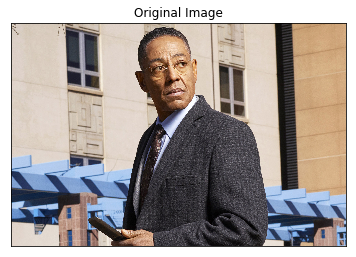

In [14]:
# Load in the image
image = cv2.imread('images/gus.jpg')

# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Original Image')
ax1.imshow(image)

### (IMPLEMENTATION) Use blurring to hide the identity of an individual in an image

The idea here is to 1) automatically detect the face in this image, and then 2) blur it out!  Make sure to adjust the parameters of the *averaging* blur filter to completely obscure this person's identity.

found 5 faces
processing face... 766 86 411 411 


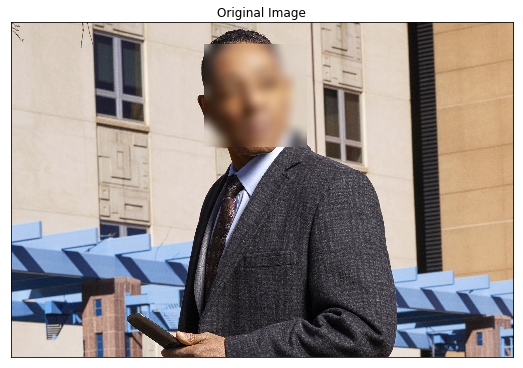

In [15]:
## TODO: Implement face detection
image = cv2.imread("images/gus.jpg")
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
face_c = cv2.CascadeClassifier("detector_architectures/haarcascade_frontalface_default.xml")
faces = face_c.detectMultiScale(gray)
print("found {} faces".format(len(faces)))
kernel = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

## TODO: Blur the bounding box around each detected face using an averaging filter and display the result
for (x, y, w, h) in faces:
    # discard small faces as they are mistakes
    if (w < 200):
        continue
    print("processing face... {} {} {} {} ".format(x, y, w, h))
    roi = image[y:y+h, x:x+w]
    # i'm using GaussianBlur instead of using filter2D with the above kernel
    roi = cv2.GaussianBlur(roi, (71, 71), 20, 20)
    image[y:y+h, x:x+w] = roi

# Display the image
fig = plt.figure(figsize = (9, 9))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Original Image')
ax1.imshow(image)

---
<a id='step5'></a>

## Step 5: Create a CNN to Recognize Facial Keypoints

OpenCV is often used in practice with other machine learning and deep learning libraries to produce interesting results.  In this stage of the project you will create your own end-to-end pipeline - employing convolutional networks in keras along with OpenCV - to apply a "selfie" filter to streaming video and images.  

You will start by creating and then training a convolutional network that can detect facial keypoints in a small dataset of cropped images of human faces.  We then guide you towards OpenCV to expanding your detection algorithm to more general images.  What are facial keypoints?  Let's take a look at some examples.

<img src="images/keypoints_test_results.png" width=400 height=300/>

Facial keypoints (also called facial landmarks) are the small blue-green dots shown on each of the faces in the image above - there are 15 keypoints marked in each image.  They mark important areas of the face - the eyes, corners of the mouth, the nose, etc.  Facial keypoints can be used in a variety of machine learning applications from face and emotion recognition to commercial applications like the image filters popularized by Snapchat.

Below we illustrate a filter that, using the results of this section, automatically places sunglasses on people in images (using the facial keypoints to place the glasses correctly on each face).  Here, the facial keypoints have been colored lime green for visualization purposes.

<img src="images/obamas_with_shades.png" width=1000 height=1000/>

### Make a facial keypoint detector

But first things first: how can we make a facial keypoint detector?  Well, at a high level, notice that facial keypoint detection is a *regression problem*.  A single face corresponds to a set of 15 facial keypoints (a set of 15 corresponding $(x, y)$ coordinates, i.e., an output point).  Because our input data are images, we can employ a *convolutional neural network* to recognize patterns in our images and learn how to identify these keypoint given sets of labeled data.

In order to train a regressor, we need a training set - a set of facial image / facial keypoint pairs to train on.  For this we will be using [this dataset from Kaggle](https://www.kaggle.com/c/facial-keypoints-detection/data). We've already downloaded this data and placed it in the `data` directory. Make sure that you have both the *training* and *test* data files.  The training dataset contains several thousand $96 \times 96$ grayscale images of cropped human faces, along with each face's 15 corresponding facial keypoints (also called landmarks) that have been placed by hand, and recorded in $(x, y)$ coordinates.  This wonderful resource also has a substantial testing set, which we will use in tinkering with our convolutional network.

To load in this data, run the Python cell below - notice we will load in both the training and testing sets.

The `load_data` function is in the included `utils.py` file.

The `load_data` function in `utils.py` originates from this excellent [blog post](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/), which you are *strongly* encouraged to read.  Please take the time now to review this function.  Note how the output values - that is, the coordinates of each set of facial landmarks - have been normalized to take on values in the range $[-1, 1]$, while the pixel values of each input point (a facial image) have been normalized to the range $[0,1]$.  

Note: the original Kaggle dataset contains some images with several missing keypoints.  For simplicity, the `load_data` function removes those images with missing labels from the dataset.  As an __*optional*__ extension, you are welcome to amend the `load_data` function to include the incomplete data points. 

### Visualize the Training Data

Execute the code cell below to visualize a subset of the training data.

For each training image, there are two landmarks per eyebrow (**four** total), three per eye (**six** total), **four** for the mouth, and **one** for the tip of the nose.  

Review the `plot_data` function in `utils.py` to understand how the 30-dimensional training labels in `y_train` are mapped to facial locations, as this function will prove useful for your pipeline.

### (IMPLEMENTATION) Specify the CNN Architecture

In this section, you will specify a neural network for predicting the locations of facial keypoints.  Use the code cell below to specify the architecture of your neural network.  We have imported some layers that you may find useful for this task, but if you need to use more Keras layers, feel free to import them in the cell.

Your network should accept a $96 \times 96$ grayscale image as input, and it should output a vector with 30 entries, corresponding to the predicted (horizontal and vertical) locations of 15 facial keypoints.  If you are not sure where to start, you can find some useful starting architectures in [this blog](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/), but you are not permitted to copy any of the architectures that you find online.

In [18]:
# Import deep learning resources from Keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.layers import Flatten, Dense, Activation
from keras.layers.normalization import BatchNormalization

## TODO: Specify a CNN architecture
# Your model should accept 96x96 pixel graysale images in
# It should have a fully-connected output layer with 30 values (2 for each facial keypoint)
model = Sequential()

model.add(Convolution2D(40, kernel_size=7, padding="same", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Convolution2D(80, kernel_size=5, padding="same"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Convolution2D(160, kernel_size=3, padding="same"))
model.add(MaxPooling2D(pool_size=2))

model.add(GlobalAveragePooling2D())
model.add(Dense(300))
model.add(Dropout(0.2))
model.add(Dense(30))
# Summarize the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 40)        2000      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 40)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 40)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 80)        80080     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 80)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 80)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 160)       115360    
__________

---
<a id='step6'></a>

## Step 6: Compile and Train the Model

After specifying your architecture, you'll need to compile and train the model to detect facial keypoints'

### (IMPLEMENTATION) Compile and Train the Model

Use the `compile` [method](https://keras.io/models/sequential/#sequential-model-methods) to configure the learning process.  Experiment with your choice of [optimizer](https://keras.io/optimizers/); you may have some ideas about which will work best (`SGD` vs. `RMSprop`, etc), but take the time to empirically verify your theories.

Use the `fit` [method](https://keras.io/models/sequential/#sequential-model-methods) to train the model.  Break off a validation set by setting `validation_split=0.2`.  Save the returned `History` object in the `history` variable.  

Experiment with your model to minimize the validation loss (measured as mean squared error). A very good model will achieve about 0.0015 loss (though it's possible to do even better).  When you have finished training, [save your model](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) as an HDF5 file with file path `my_model.h5`.

In [ ]:
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

from keras.callbacks import ModelCheckpoint

## TODO: Compile the model
checkpointer = ModelCheckpoint(filepath='glasses_testing_parameters.h5', verbose=1, save_best_only=True)

model.compile(optimizer='adamax', loss="mean_squared_error", metrics=['accuracy'])
hist = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1, validation_split=0.2, callbacks=[checkpointer])
## TODO: Train the model

## TODO: Save the model as model.h5
model.save('glasses_testing_parameters.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/100
1712/1712 [==============================] - 53s - loss: 0.0300 - acc: 0.4907 - val_loss: 0.0089 - val_acc: 0.6963
Epoch 2/100
1712/1712 [==============================] - 51s - loss: 0.0093 - acc: 0.5812 - val_loss: 0.0054 - val_acc: 0.6963
Epoch 3/100
1712/1712 [==============================] - 51s - loss: 0.0081 - acc: 0.5940 - val_loss: 0.0058 - val_acc: 0.6939
Epoch 4/100
1712/1712 [==============================] - 319s - loss: 0.0074 - acc: 0.6174 - val_loss: 0.0048 - val_acc: 0.6963
Epoch 5/100
1712/1712 [==============================] - 55s - loss: 0.0073 - acc: 0.6192 - val_loss: 0.0057 - val_acc: 0.6963
Epoch 6/100
1712/1712 [==============================] - 53s - loss: 0.0069 - acc: 0.6244 - val_loss: 0.0061 - val_acc: 0.6963
Epoch 7/100
1712/1712 [==============================] - 51s - loss: 0.0065 - acc: 0.6291 - val_loss: 0.0047 - val_acc: 0.6963
Epoch 8/100
1712/1712 [==============================] - 53s - 

---
<a id='step7'></a>

## Step 7: Visualize the Loss and Test Predictions

### (IMPLEMENTATION)  Answer a few questions and visualize the loss

__Question 1:__ Outline the steps you took to get to your final neural network architecture and your reasoning at each step.

__Answer:__


__Question 2:__ Defend your choice of optimizer.  Which optimizers did you test, and how did you determine which worked best?

__Answer:__ 


Use the code cell below to plot the training and validation loss of your neural network.  You may find [this resource](http://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/) useful.

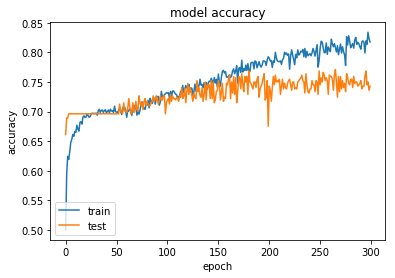

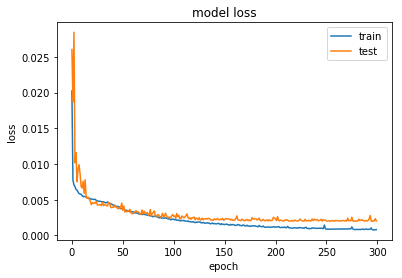

In [41]:
## TODO: Visualize the training and validation loss of your neural network
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

__Question 3:__  Do you notice any evidence of overfitting or underfitting in the above plot?  If so, what steps have you taken to improve your model?  Note that slight overfitting or underfitting will not hurt your chances of a successful submission, as long as you have attempted some solutions towards improving your model (such as _regularization, dropout, increased/decreased number of layers, etc_).

__Answer:__

### Visualize a Subset of the Test Predictions

Execute the code cell below to visualize your model's predicted keypoints on a subset of the testing images.

## Load the Trained Model

In [25]:
from keras.models import load_model
model = load_model('adamax_dropout_300e.h5')
face_cascade = cv2.CascadeClassifier("detector_architectures/haarcascade_frontalface_default.xml")

## BLurring Faces

found 2 faces
(1500, 1110, 3)
processing face... 264 298 573 573 
processing face... 296 770 537 537 


''

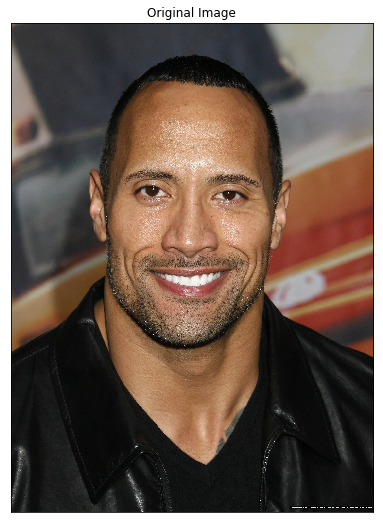

In [44]:
image = cv2.imread("dtrj.jpg")
# image = cv2.imread("images/gus.jpg")
# image = cv2.imread("images/fawzia.jpg")
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
face_c = cv2.CascadeClassifier("detector_architectures/haarcascade_frontalface_default.xml")
faces = face_c.detectMultiScale(gray)
print("found {} faces".format(len(faces)))
kernel = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

print(image.shape)

## TODO: Blur the bounding box around each detected face using an averaging filter and display the result
for (x, y, w, h) in faces:
    # discard small faces as they are mistakes
    if (w < 200):
        continue
    print("processing face... {} {} {} {} ".format(x, y, w, h))
    roi = image[y:y+h, x:x+w]
    # i'm using GaussianBlur instead of using filter2D with the above kernel
    roi = cv2.GaussianBlur(roi, (71, 71), 20, 20)
    image[y:y+h, x:x+w] = roi

# Display the image
fig = plt.figure(figsize = (9, 9))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Original Image')
ax1.imshow(image)
""""""

## Load Glasses Detector

"\nresized = cv2.resize(roi, (96, 96))\npred = np.array([resized])/255.\npred = pred[..., np.newaxis]\nnp.moveaxis(pred, 1, 3)\ny_pred = model.predict(pred)\n\nX_test = np.copy(copy_image)\ny_test = model.predict(X_test)\n\nfig = plt.figure(figsize = (9, 9))\n\nax = fig.add_subplot(111)\nplot_data(X_test, y_test, ax)\nax1.set_xticks([])\nax1.set_yticks([])\nax1.set_title('Original Image')\nax1.imshow(image)\n"

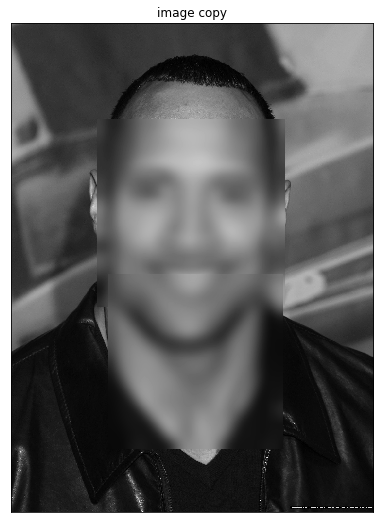

In [42]:
copy_image = np.copy(image)

image = cv2.cvtColor(copy_image, cv2.COLOR_BGR2RGB)
image_copy = cv2.cvtColor(copy_image, cv2.COLOR_RGB2GRAY)

fig = plt.figure(figsize = (9,9))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('image copy')
ax1.imshow(image_copy, cmap='gray')

"""
resized = cv2.resize(roi, (96, 96))
pred = np.array([resized])/255.
pred = pred[..., np.newaxis]
np.moveaxis(pred, 1, 3)
y_pred = model.predict(pred)

X_test = np.copy(copy_image)
y_test = model.predict(X_test)

fig = plt.figure(figsize = (9, 9))

ax = fig.add_subplot(111)
plot_data(X_test, y_test, ax)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Original Image')
ax1.imshow(image)
"""

---
<a id='step8'></a>

## Step 8: Complete the pipeline

With the work you did in Sections 1 and 2 of this notebook, along with your freshly trained facial keypoint detector, you can now complete the full pipeline.  That is given a color image containing a person or persons you can now 

- Detect the faces in this image automatically using OpenCV
- Predict the facial keypoints in each face detected in the image
- Paint predicted keypoints on each face detected

In this Subsection you will do just this!  

### (IMPLEMENTATION) Facial Keypoints Detector

Use the OpenCV face detection functionality you built in previous Sections to expand the functionality of your keypoints detector to color images with arbitrary size.  Your function should perform the following steps

1. Accept a color image.
2. Convert the image to grayscale.
3. Detect and crop the face contained in the image.
4. Locate the facial keypoints in the cropped image.
5. Overlay the facial keypoints in the original (color, uncropped) image.

**Note**: step 4 can be the trickiest because remember your convolutional network is only trained to detect facial keypoints in $96 \times 96$ grayscale images where each pixel was normalized to lie in the interval $[0,1]$, and remember that each facial keypoint was normalized during training to the interval $[-1,1]$.  This means - practically speaking - to paint detected keypoints onto a test face you need to perform this same pre-processing to your candidate face  - that is after detecting it you should resize it to $96 \times 96$ and normalize its values before feeding it into your facial keypoint detector.  To be shown correctly on the original image the output keypoints from your detector then need to be shifted and re-normalized from the interval $[-1,1]$ to the width and height of your detected face.

When complete you should be able to produce example images like the one below

<img src="images/obamas_with_keypoints.png" width=1000 height=1000/>

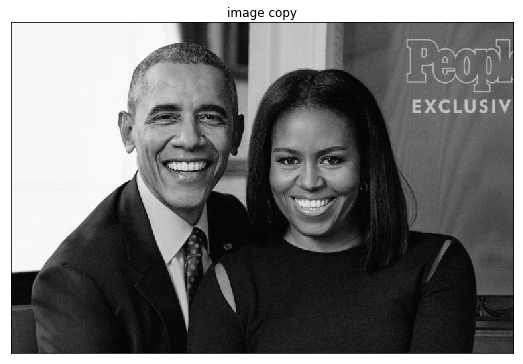

In [46]:
# Load in color image for face detection
image = cv2.imread('images/obamas4.jpg')


# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# plot our image
fig = plt.figure(figsize = (9,9))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('image copy')
ax1.imshow(image_copy, cmap='gray')

In [48]:
### TODO: Use the face detection code we saw in Section 1 with your trained conv-net 
## TODO : Paint the predicted keypoints on the test image
model.load_weights("./my_model.h5")
face_cascade = cv2.CascadeClassifier("detector_architectures/haarcascade_frontalface_default.xml")

faces = face_cascade.detectMultiScale(image_copy, 1.25, 6)

def denormalize(value):
    return int(round(value * 48 + 48))

image_with_landmarks = image.copy()

for (x, y, w, h) in faces:
    copy = image_copy.copy()
    roi = copy[y:y+h, x:x+w]
    resized = cv2.resize(roi, (96, 96))
    pred = np.array([resized])/255.
    pred = pred[..., np.newaxis]
    np.moveaxis(pred, 1, 3)
    y_pred = model.predict(pred)
    den_pred = list(map(denormalize, y_pred[0]))
    print("Original w: {}, ratio: {}".format(w, float(w/96)))
    scale = w / 96
    for i in range(0, 15):
        cx = x + int((den_pred[i * 2]) * scale)
        cy = y + int((den_pred[i * 2 + 1]) * scale)
        cv2.circle(image_with_landmarks, (cx, cy), 1, (0, 255, 0), 3)

    print(y_pred, den_pred)


Original w: 175, ratio: 1.8229166666666667
[[ 0.42075288 -0.20675005 -0.39494514 -0.22094652  0.25729054 -0.17830971
   0.59798014 -0.19054526 -0.21550599 -0.18560587 -0.58867979 -0.20813811
   0.24568784 -0.30497384  0.69121486 -0.3439323  -0.16397467 -0.33568695
  -0.6871959  -0.36684632  0.11805457  0.29783911  0.47084755  0.52025974
  -0.44774702  0.53067851  0.05085754  0.61957586  0.03920479  0.76660007]] [68, 38, 29, 37, 60, 39, 77, 39, 38, 39, 20, 38, 60, 33, 81, 31, 40, 32, 15, 30, 54, 62, 71, 73, 27, 73, 50, 78, 50, 85]
Original w: 166, ratio: 1.7291666666666667
[[ 0.42415851 -0.20319177 -0.3437075  -0.16280714  0.24826491 -0.16396475
   0.60135311 -0.19212435 -0.1926633  -0.14342988 -0.50952846 -0.13673395
   0.14290811 -0.27678776  0.72607505 -0.35377327 -0.19093859 -0.2397158
  -0.64192486 -0.28672421 -0.05527303  0.24855581  0.41645521  0.58418483
  -0.27383336  0.6133123   0.03443595  0.60133362  0.04221453  0.75358802]] [68, 38, 32, 40, 60, 40, 77, 39, 39, 41, 24, 41, 5

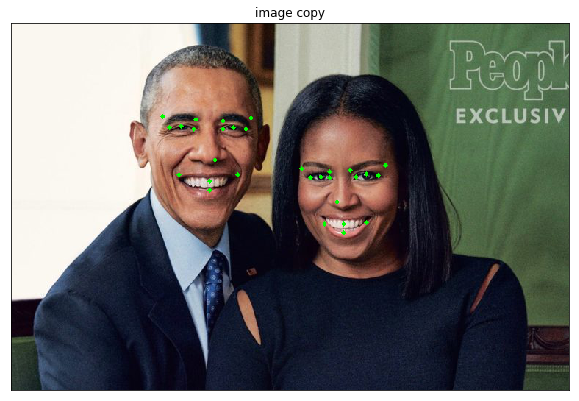

In [49]:
fig = plt.figure(figsize = (10, 10))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('image copy')
ax1.imshow(image_with_landmarks)

### (Optional) Further Directions - add a filter using facial keypoints to your laptop camera

Now you can add facial keypoint detection to your laptop camera - as illustrated in the gif below.

<img src="images/facial_keypoint_test.gif" width=400 height=300/>

The next Python cell contains the basic laptop video camera function used in the previous optional video exercises.  Combine it with the functionality you developed for keypoint detection and marking in the previous exercise and you should be good to go!

In [ ]:
import cv2
import time 
from keras.models import load_model
def laptop_camera_go():
    # Create instance of video capturer
    cv2.namedWindow("face detection activated")
    vc = cv2.VideoCapture(0)

    # Try to get the first frame
    if vc.isOpened(): 
        rval, frame = vc.read()
    else:
        rval = False
    
    # keep video stream open
    while rval:
        # plot image from camera with detections marked
        cv2.imshow("face detection activated", frame)
        
        # exit functionality - press any key to exit laptop video
        key = cv2.waitKey(20)
        if key > 0: # exit by pressing any key
            # destroy windows
            cv2.destroyAllWindows()
            
            # hack from stack overflow for making sure window closes on osx --> https://stackoverflow.com/questions/6116564/destroywindow-does-not-close-window-on-mac-using-python-and-opencv
            for i in range (1,5):
                cv2.waitKey(1)
            return
        
        # read next frame
        time.sleep(0.05)             # control framerate for computation - default 20 frames per sec
        rval, frame = vc.read()  

In [ ]:
# Run your keypoint face painter
laptop_camera_go()

### (Optional) Further Directions - add a filter using facial keypoints

Using your freshly minted facial keypoint detector pipeline you can now do things like add fun filters to a person's face automatically.  In this optional exercise you can play around with adding sunglasses automatically to each individual's face in an image as shown in a demonstration image below.

<img src="images/obamas_with_shades.png" width=1000 height=1000/>

To produce this effect an image of a pair of sunglasses shown in the Python cell below.

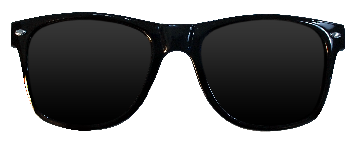

In [50]:
# Load in sunglasses image - note the usage of the special option
# cv2.IMREAD_UNCHANGED, this option is used because the sunglasses 
# image has a 4th channel that allows us to control how transparent each pixel in the image is
sunglasses = cv2.imread("images/sunglasses_4.png", cv2.IMREAD_UNCHANGED)

# Plot the image
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.imshow(sunglasses)
ax1.axis('off');

This image is placed over each individual's face using the detected eye points to determine the location of the sunglasses, and eyebrow points to determine the size that the sunglasses should be for each person (one could also use the nose point to determine this).  

Notice that this image actually has *4 channels*, not just 3. 

In [51]:
# Print out the shape of the sunglasses image
print ('The sunglasses image has shape: ' + str(np.shape(sunglasses)))

The sunglasses image has shape: (1123, 3064, 4)


It has the usual red, blue, and green channels any color image has, with the 4th channel representing the transparency level of each pixel in the image.  Here's how the transparency channel works: the lower the value, the more transparent the pixel will become.  The lower bound (completely transparent) is zero here, so any pixels set to 0 will not be seen. 

This is how we can place this image of sunglasses on someone's face and still see the area around of their face where the sunglasses lie - because these pixels in the sunglasses image have been made completely transparent.

Lets check out the alpha channel of our sunglasses image in the next Python cell.  Note because many of the pixels near the boundary are transparent we'll need to explicitly print out non-zero values if we want to see them. 

In [52]:
# Print out the sunglasses transparency (alpha) channel
alpha_channel = sunglasses[:,:,3]
print ('the alpha channel here looks like')
print (alpha_channel)

# Just to double check that there are indeed non-zero values
# Let's find and print out every value greater than zero
values = np.where(alpha_channel != 0)
print ('\n the non-zero values of the alpha channel look like')
print (values)

the alpha channel here looks like
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]

 the non-zero values of the alpha channel look like
(array([  17,   17,   17, ..., 1109, 1109, 1109]), array([ 687,  688,  689, ..., 2376, 2377, 2378]))


This means that when we place this sunglasses image on top of another image, we can use the transparency channel as a filter to tell us which pixels to overlay on a new image (only the non-transparent ones with values greater than zero).

One last thing: it's helpful to understand which keypoint belongs to the eyes, mouth, etc. So, in the image below, we also display the index of each facial keypoint directly on the image so that you can tell which keypoints are for the eyes, eyebrows, etc.

<img src="images/obamas_points_numbered.png" width=500 height=500/>

With this information, you're well on your way to completing this filtering task!  See if you can place the sunglasses automatically on the individuals in the image loaded in / shown in the next Python cell.

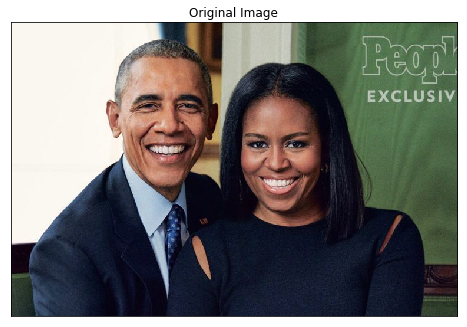

In [53]:
# Load in color image for face detection
image = cv2.imread('images/obamas4.jpg')

# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Plot the image
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Original Image')
ax1.imshow(image)

In [54]:
## (Optional) TODO: Use the face detection code we saw in Section 1 with your trained conv-net to put
## sunglasses on the individuals in our test image



###  (Optional) Further Directions - add a filter using facial keypoints to your laptop camera 

Now you can add the sunglasses filter to your laptop camera - as illustrated in the gif below.

<img src="images/mr_sunglasses.gif" width=250 height=250/>

The next Python cell contains the basic laptop video camera function used in the previous optional video exercises.  Combine it with the functionality you developed for adding sunglasses to someone's face in the previous optional exercise and you should be good to go!

In [ ]:
import cv2
import time 
from keras.models import load_model
import numpy as np

def laptop_camera_go():
    # Create instance of video capturer
    cv2.namedWindow("face detection activated")
    vc = cv2.VideoCapture(0)

    # try to get the first frame
    if vc.isOpened(): 
        rval, frame = vc.read()
    else:
        rval = False
    
    # Keep video stream open
    while rval:
        # Plot image from camera with detections marked
        cv2.imshow("face detection activated", frame)
        
        # Exit functionality - press any key to exit laptop video
        key = cv2.waitKey(20)
        if key > 0: # exit by pressing any key
            # Destroy windows 
            cv2.destroyAllWindows()
            
            for i in range (1,5):
                cv2.waitKey(1)
            return
        
        # Read next frame
        time.sleep(0.05)             # control framerate for computation - default 20 frames per sec
        rval, frame = vc.read()    
        

In [ ]:
# Load facial landmark detector model
model = load_model('my_model.h5')

# Run sunglasses painter
laptop_camera_go()